In [ ]:
# We install darts
!pip install u8darts[torch] --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.4/57.4 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.3/46.3 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.6/200.6 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.1/823.1 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.4/354.4 kB 24.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 37.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 32.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 35.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Necessary imports
import pandas as pd
import zipfile
import os
import numpy as np
import matplotlib.pyplot as plt
import joblib
from darts import TimeSeries
from darts.models import LightGBMModel, BlockRNNModel, TFTModel, BlockRNNModel, ConformalQRModel
from darts.dataprocessing.transformers import Scaler
from darts import concatenate, metrics

# We can ignore Darts library warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# We load the test data
test_data = joblib.load('/content/drive/MyDrive/Colab Notebooks/TFG/data/01_datasets/train_test/scaled_test.pkl')

# Extract components
scaled_calib_test_series = test_data['calib_test']
scalers_test = test_data['scalers']           # the scalers to reescale the series later

# We load the test data specific
test_data_specific = joblib.load('/content/drive/MyDrive/Colab Notebooks/TFG/data/01_datasets/train_test_reduced/scaled_test_reduced.pkl')

# Extract components
scaled_calib_test_series_specific = test_data_specific['calib_test']
scalers_test_specific = test_data_specific['scalers']           # the scalers to reescale the series later

In [ ]:
# Stable time series
stationary = "0810102039_Hospitalet"

# Decreasing time series
non_stationary = "0801910054_Barcelona"

stable_ts = scaled_calib_test_series_specific[stationary]
non_stable_ts = scaled_calib_test_series[non_stationary]

# Meter IDs used
stationary = "0810102039_Hospitalet"
non_stationary = "0801910054_Barcelona"

# Create a unified scaler dictionary for the meters in use
scalers_used = {
    stationary: scalers_test_specific[stationary],
    non_stationary: scalers_test[non_stationary]
}

series_dict = {
    "0810102039_Hospitalet": stable_ts,
    "0801910054_Barcelona": non_stable_ts
}

meter_ids = list(series_dict.keys())

In [ ]:
# We load the models
models = {
    "LightGBM": LightGBMModel.load("/content/drive/MyDrive/Colab Notebooks/TFG/data/02_models/lightGBM/simple/lightgbm_model.pkl"),
    "BlockRNN": BlockRNNModel.load("/content/drive/MyDrive/Colab Notebooks/TFG/data/02_models/blockRNN/simple/blockRNN_model.pkl"),
    "TFT": TFTModel.load("/content/drive/MyDrive/Colab Notebooks/TFG/data/02_models/TFT/simple/TFT_model.pkl"),
}

In [ ]:


# Constants
start_date = pd.Timestamp("2023-11-6")
quantiles = [0.05, 0.5, 0.95]
pred_kwargs = {"predict_likelihood_parameters": True, "verbose": True}
q_interval = [(0.05, 0.95)]
q_range = [0.9]

# Initialize containers
all_model_results = []
all_hfcs = {}
all_bt_results = {}

# Loop through models
for model_name, model in models.items():
    all_hfcs[model_name] = {}
    all_bt_results[model_name] = {}
    all_hfcs[f"{model_name} CQR"] = {}
    all_bt_results[f"{model_name} CQR"] = {}

    # Wrap base model with CQR
    cp_model = ConformalQRModel(
        model=model,
        quantiles=quantiles,
        symmetric=False
    )
    q_interval = cp_model.q_interval
    q_range = cp_model.interval_range

    for meter_id in meter_ids:
        ts = series_dict[meter_id]
        scaler = scalers_used[meter_id]

        # === 1. Original model forecasts ===
        hfcs = model.historical_forecasts(
            series=ts,
            forecast_horizon=7,
            start=start_date,
            last_points_only=False,
            stride=7,
            retrain=False,
            **pred_kwargs,
        )

        # Interval widths
        widths = []
        for forecast in hfcs:
            q05 = forecast["Consumption per meter_q0.05"]
            q95 = forecast["Consumption per meter_q0.95"]
            q05_orig = scaler.inverse_transform(q05)
            q95_orig = scaler.inverse_transform(q95)
            width = (q95_orig - q05_orig).values()
            widths.append(width)
        mean_width = np.mean([np.mean(w) for w in widths])

        # Backtest
        bt = model.backtest(
            ts,
            historical_forecasts=hfcs,
            last_points_only=False,
            metric=[metrics.mic, metrics.miw],
            metric_kwargs={"q_interval": q_interval},
            retrain=False
        )

        df_result = pd.DataFrame({
            "Model": model_name,
            "Meter ID": meter_id,
            "Interval": q_range,
            "Coverage": bt[0],
            "Width": bt[1],
            "Width rescaled": mean_width
        })

        all_model_results.append(df_result)
        all_hfcs[model_name][meter_id] = hfcs
        all_bt_results[model_name][meter_id] = df_result

        # === 2. CQR forecasts ===
        cqr_hfcs = cp_model.historical_forecasts(
            series=ts,
            forecast_horizon=7,
            start=start_date,
            last_points_only=False,
            stride=7,
            **pred_kwargs,
        )

        widths_cqr = []
        for forecast in cqr_hfcs:
            q05 = forecast["Consumption per meter_q0.05"]
            q95 = forecast["Consumption per meter_q0.95"]
            q05_orig = scaler.inverse_transform(q05)
            q95_orig = scaler.inverse_transform(q95)
            width = (q95_orig - q05_orig).values()
            widths_cqr.append(width)
        mean_width_cqr = np.mean([np.mean(w) for w in widths_cqr])

        cqr_bt = cp_model.backtest(
            ts,
            historical_forecasts=cqr_hfcs,
            last_points_only=False,
            retrain=False,
            metric=[metrics.mic, metrics.miw],
            metric_kwargs={"q_interval": q_interval},
        )

        df_cqr_result = pd.DataFrame({
            "Model": f"{model_name} CQR",
            "Meter ID": meter_id,
            "Interval": q_range,
            "Coverage": cqr_bt[0],
            "Width": cqr_bt[1],
            "Width rescaled": mean_width_cqr
        })

        all_model_results.append(df_cqr_result)
        all_hfcs[f"{model_name} CQR"][meter_id] = cqr_hfcs
        all_bt_results[f"{model_name} CQR"][meter_id] = df_cqr_result

# Combine all results
final_results = pd.concat(all_model_results, ignore_index=True)

conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 423.08it/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 388.41it/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 395.12it/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 412.70it/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 435.41it/s]


In [ ]:
final_results

,Model,Meter ID,Interval,Coverage,Width,Width rescaled
0,LightGBM,0810102039_Hospitalet,0.9,0.750000,0.383099,5.807786
1,LightGBM CQR,0810102039_Hospitalet,0.9,0.839286,0.473112,7.172385
2,LightGBM,0801910054_Barcelona,0.9,0.589286,0.164651,1.745296
3,LightGBM CQR,0801910054_Barcelona,0.9,0.982143,0.537583,5.698375
4,BlockRNN,0810102039_Hospitalet,0.9,0.892857,0.398614,6.042989
5,BlockRNN CQR,0810102039_Hospitalet,0.9,0.928571,0.498518,7.557529
6,BlockRNN,0801910054_Barcelona,0.9,0.678571,0.187411,1.986555
7,BlockRNN CQR,0801910054_Barcelona,0.9,0.946429,0.384226,4.072798
8,TFT,0810102039_Hospitalet,0.9,0.857143,0.408334,6.190344
9,TFT CQR,0810102039_Hospitalet,0.9,0.910714,0.474449,7.192654


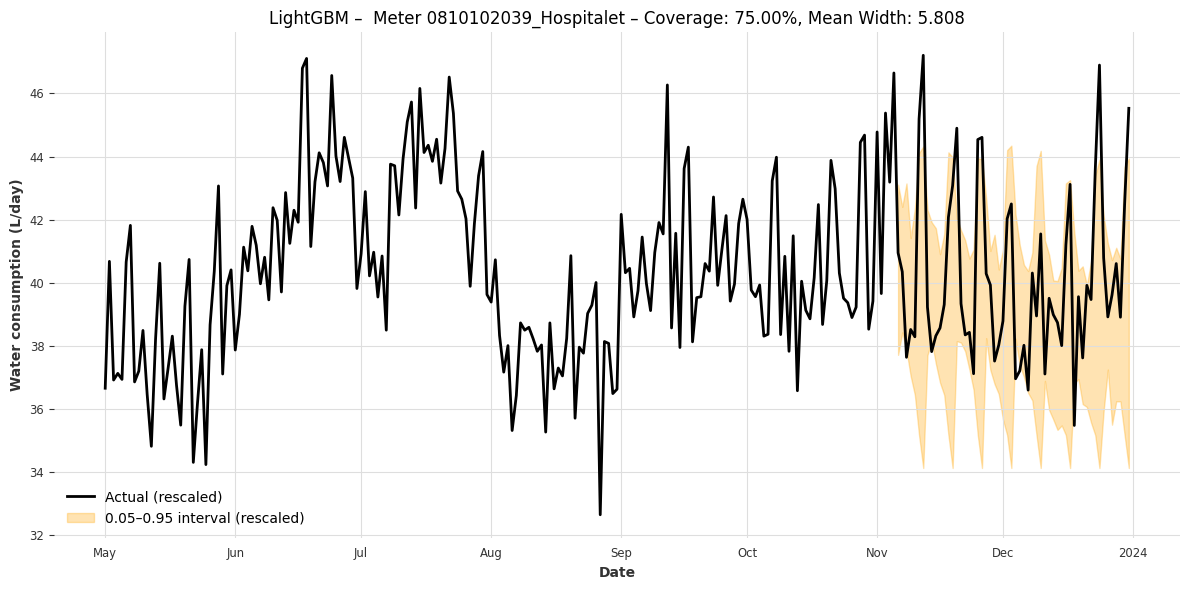

LightGBM | Meter 0810102039_Hospitalet - Coverage: 0.7500, Mean Interval Width (rescaled): 0.5461



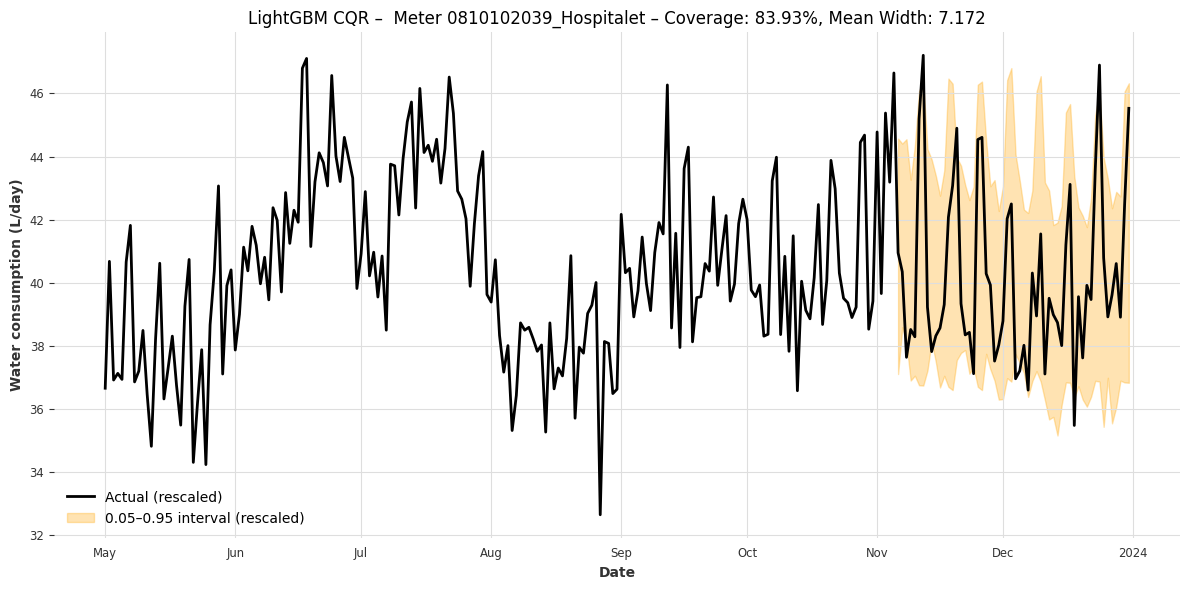

LightGBM CQR | Meter 0810102039_Hospitalet - Coverage: 0.8393, Mean Interval Width (rescaled): 0.5461



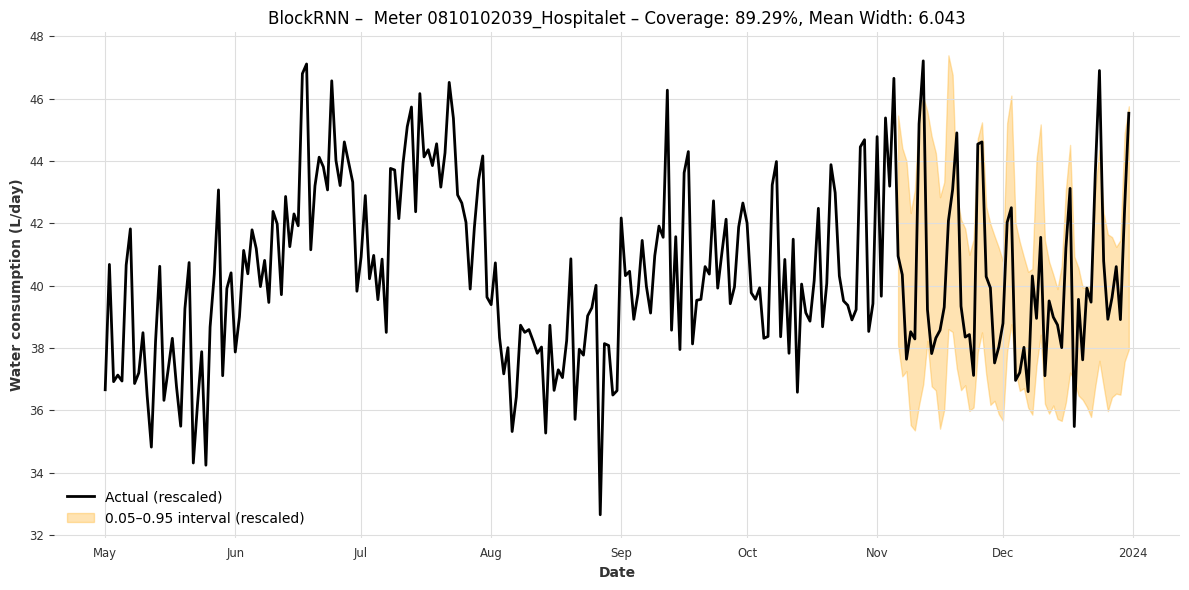

BlockRNN | Meter 0810102039_Hospitalet - Coverage: 0.8929, Mean Interval Width (rescaled): 0.5461



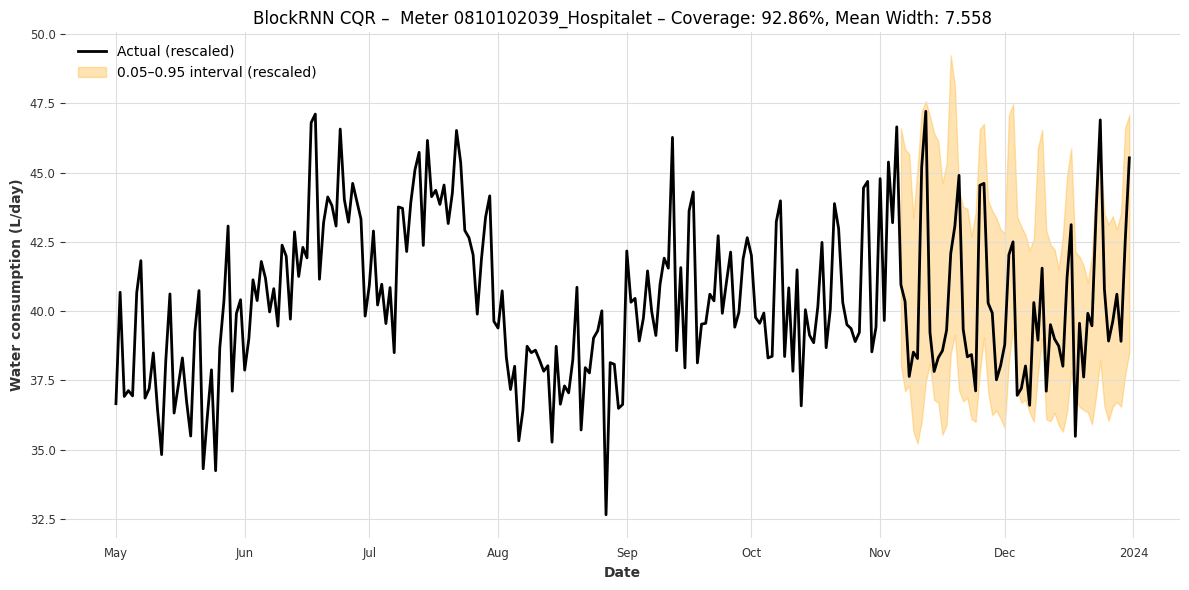

BlockRNN CQR | Meter 0810102039_Hospitalet - Coverage: 0.9286, Mean Interval Width (rescaled): 0.5461



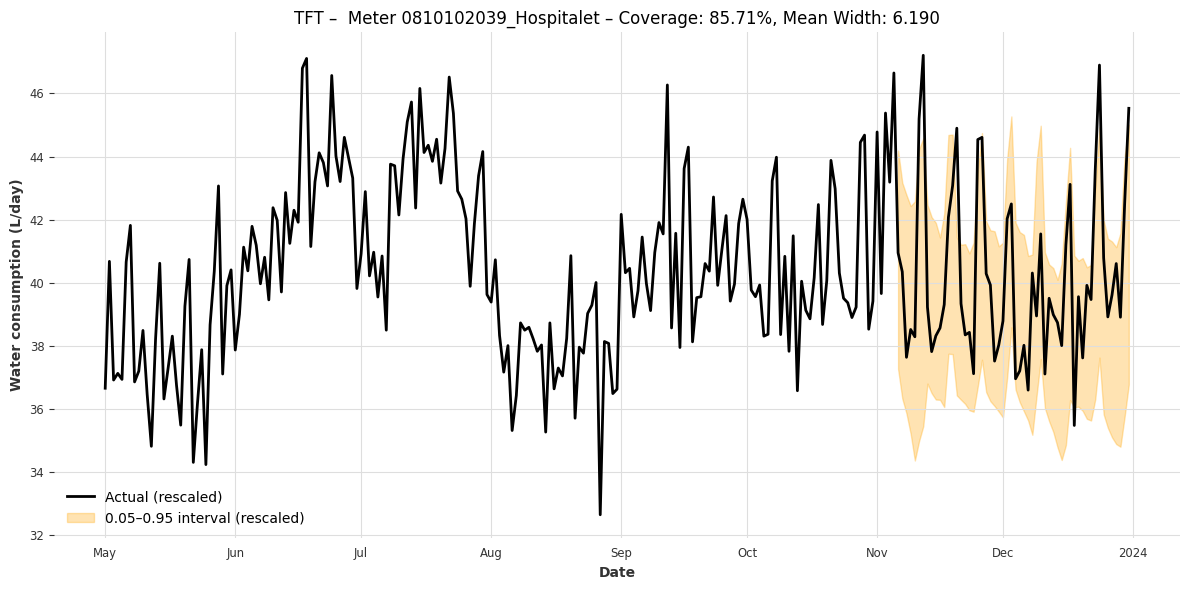

TFT | Meter 0810102039_Hospitalet - Coverage: 0.8571, Mean Interval Width (rescaled): 0.5461



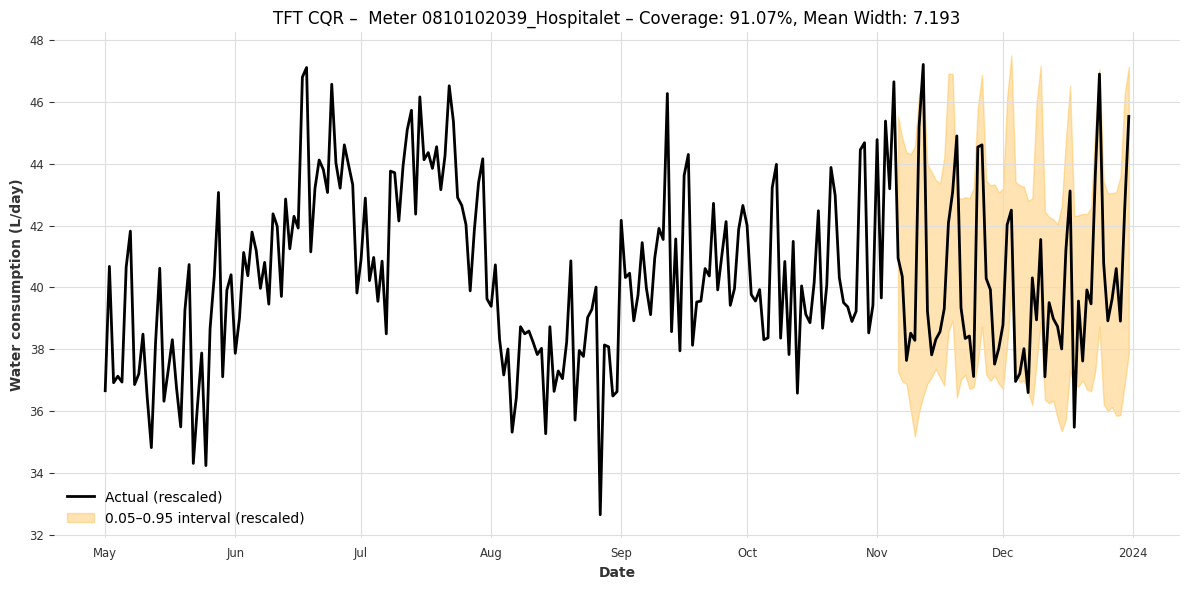

TFT CQR | Meter 0810102039_Hospitalet - Coverage: 0.9107, Mean Interval Width (rescaled): 0.5461



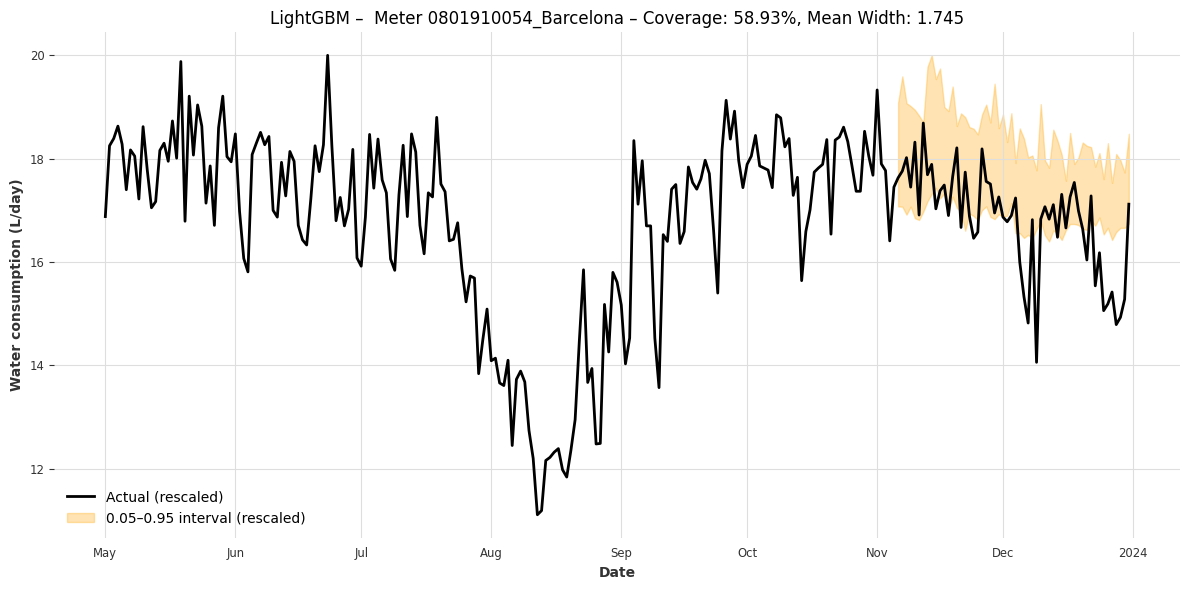

LightGBM | Meter 0801910054_Barcelona - Coverage: 0.5893, Mean Interval Width (rescaled): 0.5461



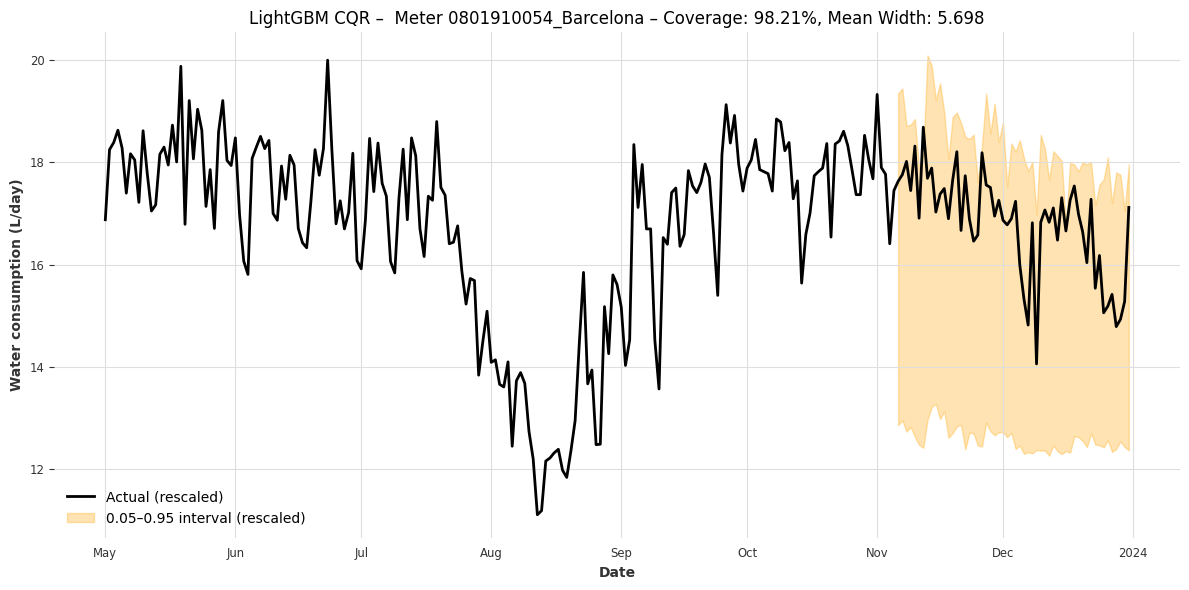

LightGBM CQR | Meter 0801910054_Barcelona - Coverage: 0.9821, Mean Interval Width (rescaled): 0.5461



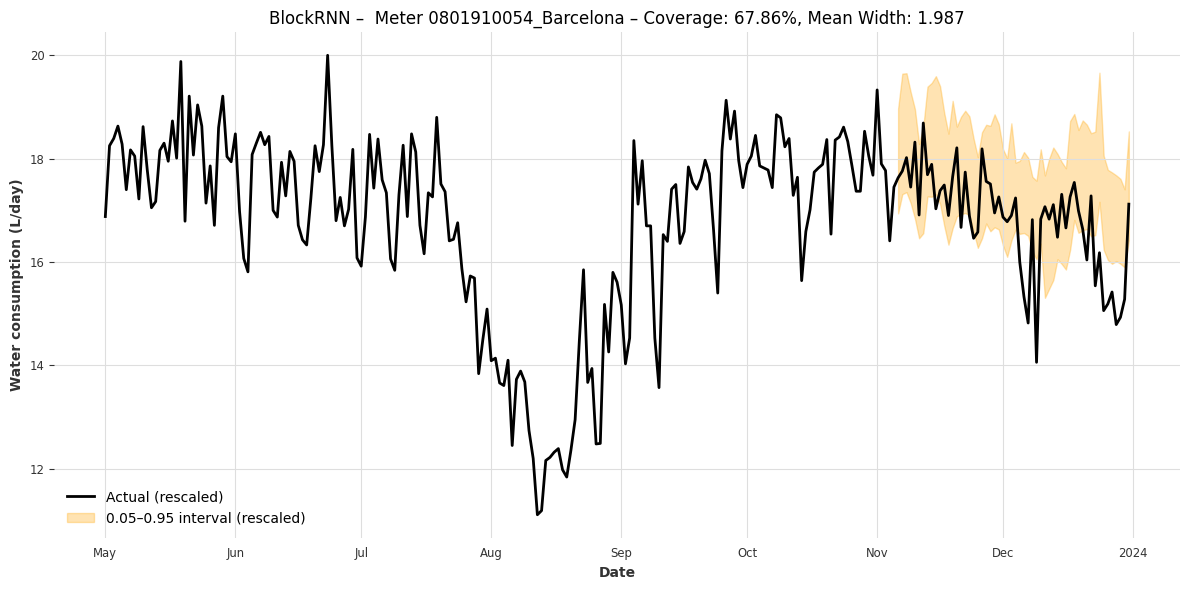

BlockRNN | Meter 0801910054_Barcelona - Coverage: 0.6786, Mean Interval Width (rescaled): 0.5461



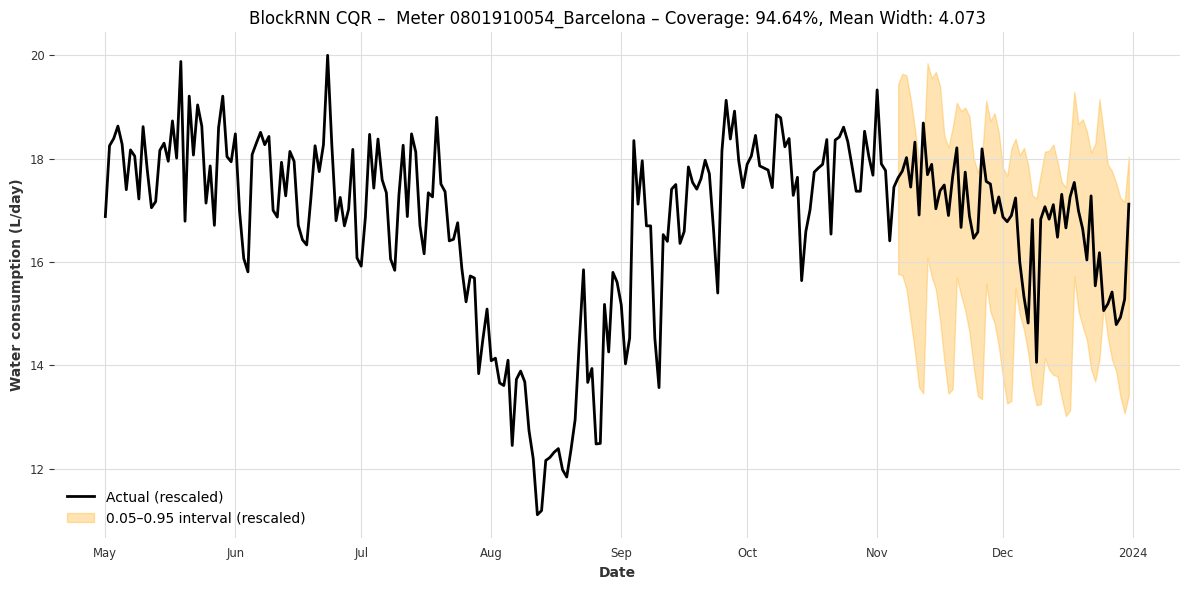

BlockRNN CQR | Meter 0801910054_Barcelona - Coverage: 0.9464, Mean Interval Width (rescaled): 0.5461



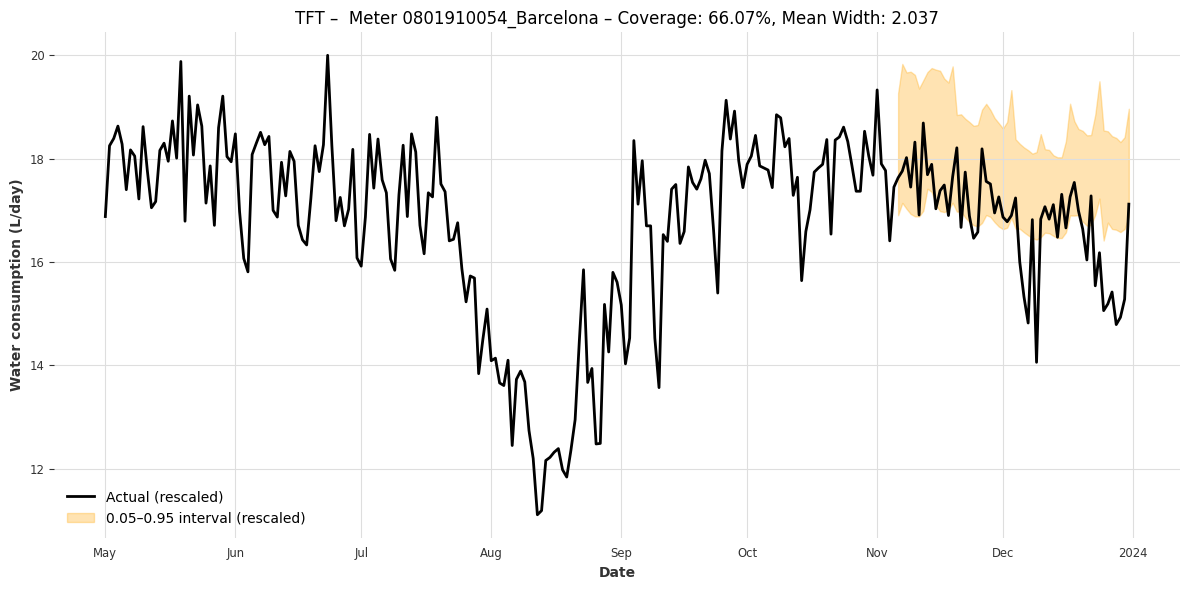

TFT | Meter 0801910054_Barcelona - Coverage: 0.6607, Mean Interval Width (rescaled): 0.5461



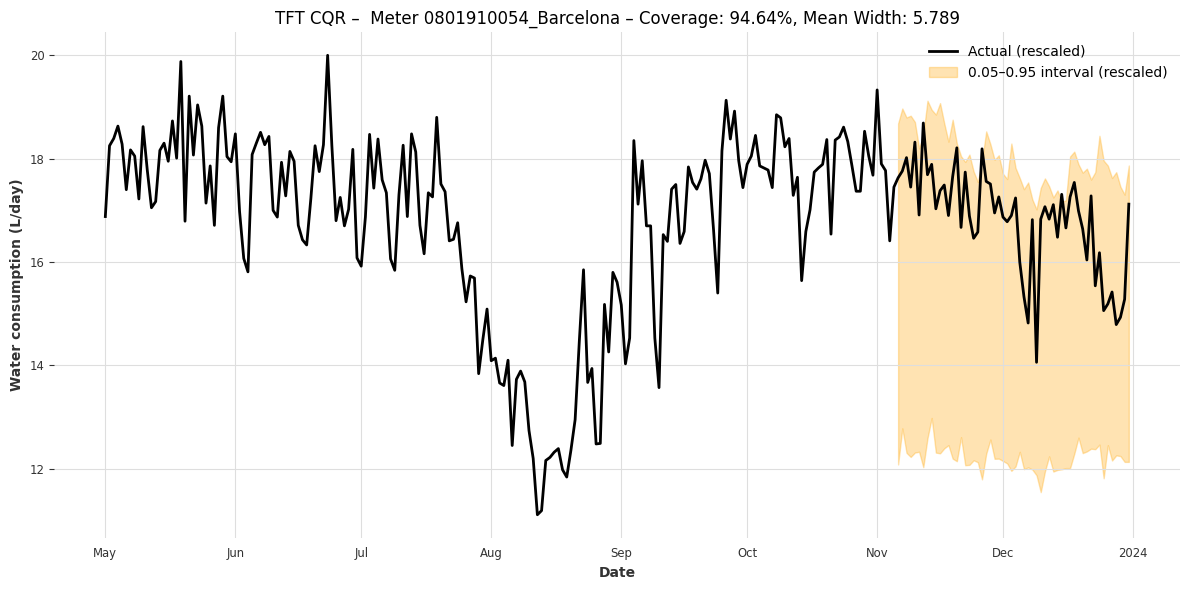

TFT CQR | Meter 0801910054_Barcelona - Coverage: 0.9464, Mean Interval Width (rescaled): 0.5461



In [ ]:
# Define base model order
base_model_names = ["LightGBM", "BlockRNN", "TFT"]

# Loop through each meter
for meter_id in meter_ids:
    ts = series_dict[meter_id]
    scaler = scalers_used[meter_id]
    ts_orig = scaler.inverse_transform(ts)

    for model_name in base_model_names:
        for variant in [model_name, f"{model_name} CQR"]:
            if meter_id not in all_hfcs[variant]:
                continue  # Skip if CQR model not evaluated for this meter

            hfcs = all_hfcs[variant][meter_id]
            df_result = all_bt_results[variant][meter_id]

            # Metrics
            coverage = df_result["Coverage"].iloc[0]
            width = df_result["Width rescaled"].iloc[0]

            # Plot setup
            fig, ax = plt.subplots(figsize=(12, 6))
            ts_orig.plot(ax=ax, label="Actual (rescaled)", lw=2)

            # Collect forecast intervals
            full_lower = []
            full_upper = []

            for forecast in hfcs:
                if ("Consumption per meter_q0.05" in forecast.components and
                    "Consumption per meter_q0.95" in forecast.components):

                    lower = forecast["Consumption per meter_q0.05"]
                    upper = forecast["Consumption per meter_q0.95"]
                    lower_orig = scaler.inverse_transform(lower)
                    upper_orig = scaler.inverse_transform(upper)

                    full_lower.append(lower_orig)
                    full_upper.append(upper_orig)

            # Plot intervals
            if full_lower and full_upper:
                combined_lower = concatenate(full_lower)
                combined_upper = concatenate(full_upper)

                ax.fill_between(
                    combined_lower.time_index,
                    combined_lower.values().flatten(),
                    combined_upper.values().flatten(),
                    color="orange",
                    alpha=0.3,
                    label="0.05–0.95 interval (rescaled)"
                )


            ax.set_title(f"{variant} –  Meter {meter_id} – Coverage: {coverage:.2%}, Mean Width: {width:.3f}")
            ax.set_ylabel("Water consumption (L/day)")
            ax.legend()
            plt.tight_layout()

            filename = f"/content/drive/MyDrive/Colab Notebooks/TFG/05_examples/{variant.replace(' ', '_')}_meter_{meter_id}.png"
            plt.savefig(filename, dpi=300)


            plt.show()

            # Print metrics
            print(f"{variant} | Meter {meter_id} - Coverage: {coverage:.4f}, Mean Interval Width (rescaled): {width_orig:.4f}\n")
